## **Import Necessary Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch

import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score

import os
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

2024-05-31 10:14:19.473287: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 10:14:19.473441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 10:14:19.627696: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Load Dataset**

In [2]:
train_df = pd.read_csv('/kaggle/input/tech-fest-1-0-ai-hackathon/train.csv')
train_df.head()

,Date_Time,Sex,Nation,Job,Freelance_Status,Genetic_Background,Therapy,Indoor_Days,Increasing_Stress,Habit_Changes,Psychological_History,Emotional_Fluctuations,Adaptation_Challenges,Job_Engagement,Social_Vulnerability,Psych_Evaluation,Support_Options,Body_Weight
0,8/27/2014 13:47,Male,United States,Business,No,No,No,15-30 days,Maybe,Maybe,No,Medium,Yes,Maybe,Yes,No,Yes,59.0
1,8/29/2014 14:31,Male,United States,Student,Yes,Yes,Yes,1-14 days,Maybe,Yes,No,High,No,Yes,Maybe,No,Not sure,58.0
2,8/27/2014 11:34,Male,US,Others,NaN,No,Yes,More than 2 months,No,No,No,High,No,Yes,No,No,Yes,70.0
3,8/28/2014 22:22,Male,United States,Housewife,No,No,Yes,15-30 days,Maybe,No,No,Low,Yes,Maybe,Yes,No,No,72.0
4,8/27/2014 14:53,Male,United States,Housewife,No,No,Yes,Go out Every day,Yes,Yes,No,Low,Yes,No,No,No,Yes,94.0


## **Data Inspection**

In [3]:
train_df.shape

(277746, 18)

In [4]:
train_df.describe()

,Body_Weight
count,277745.000000
mean,74.933777
std,14.710990
min,50.000000
25%,62.000000
50%,75.000000
75%,88.000000
max,100.000000


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277746 entries, 0 to 277745
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Date_Time               277746 non-null  object 
 1   Sex                     277746 non-null  object 
 2   Nation                  277745 non-null  object 
 3   Job                     277746 non-null  object 
 4   Freelance_Status        272781 non-null  object 
 5   Genetic_Background      277746 non-null  object 
 6   Therapy                 277745 non-null  object 
 7   Indoor_Days             277743 non-null  object 
 8   Increasing_Stress       277746 non-null  object 
 9   Habit_Changes           277746 non-null  object 
 10  Psychological_History   277744 non-null  object 
 11  Emotional_Fluctuations  277746 non-null  object 
 12  Adaptation_Challenges   277745 non-null  object 
 13  Job_Engagement          277742 non-null  object 
 14  Social_Vulnerability

### ***`Missing Values` - Check for missing values, `Freelance_Status` has missing values init.***

In [6]:
missing_values = train_df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Date_Time                    0
Sex                          0
Nation                       1
Job                          0
Freelance_Status          4965
Genetic_Background           0
Therapy                      1
Indoor_Days                  3
Increasing_Stress            0
Habit_Changes                0
Psychological_History        2
Emotional_Fluctuations       0
Adaptation_Challenges        1
Job_Engagement               4
Social_Vulnerability         0
Psych_Evaluation             2
Support_Options              4
Body_Weight                  1
dtype: int64


### ***`Fill with Mode` - Fill the categorical column with the most frequent one***

In [7]:
categorical_columns = train_df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    train_df.fillna({column: train_df[column].mode()[0]}, inplace=True)
    print('Missing values in', column, 'filled with mode')

Missing values in Date_Time filled with mode
Missing values in Sex filled with mode
Missing values in Nation filled with mode
Missing values in Job filled with mode
Missing values in Freelance_Status filled with mode
Missing values in Genetic_Background filled with mode
Missing values in Therapy filled with mode
Missing values in Indoor_Days filled with mode
Missing values in Increasing_Stress filled with mode
Missing values in Habit_Changes filled with mode
Missing values in Psychological_History filled with mode
Missing values in Emotional_Fluctuations filled with mode
Missing values in Adaptation_Challenges filled with mode
Missing values in Job_Engagement filled with mode
Missing values in Social_Vulnerability filled with mode
Missing values in Psych_Evaluation filled with mode
Missing values in Support_Options filled with mode


In [8]:
train_df.drop('Date_Time', axis=1, inplace=True)

## ***`Data Validation`***
* Same values with different cases, --> convert them into same case.
* not defined <- such rows are less in number, lets drop it.

#### ***Drop rows on following criteries***
* not defined in `Job`
* nill in 'Freelance_Status'
* nill + null in `Genetic_Background`

In [9]:
df = train_df.select_dtypes(include=['object'])

In [10]:
df = df[df['Job'] != 'not defined']
df = df[df['Freelance_Status'] != 'nill']
df = df[df['Genetic_Background'] != 'nill']
df = df[df['Genetic_Background'] != 'null']
df = df[df['Job_Engagement'] != 'nill']
df = df[df['Job_Engagement'] != 'n/a']
df = df[df['Psych_Evaluation'] != 'n/a']
df = df[df['Support_Options'] != 'n/a']

### ***Let convert them into same case***

In [11]:
for col in df.columns:
    df[col] = df[col].apply(lambda x: x.lower())

In [12]:
df.columns

Index(['Sex', 'Nation', 'Job', 'Freelance_Status', 'Genetic_Background',
       'Therapy', 'Indoor_Days', 'Increasing_Stress', 'Habit_Changes',
       'Psychological_History', 'Emotional_Fluctuations',
       'Adaptation_Challenges', 'Job_Engagement', 'Social_Vulnerability',
       'Psych_Evaluation', 'Support_Options'],
      dtype='object')

In [13]:
df.sample(5)

,Sex,Nation,Job,Freelance_Status,Genetic_Background,Therapy,Indoor_Days,Increasing_Stress,Habit_Changes,Psychological_History,Emotional_Fluctuations,Adaptation_Challenges,Job_Engagement,Social_Vulnerability,Psych_Evaluation,Support_Options
21892,male,united states,student,no,yes,no,31-60 days,yes,yes,maybe,medium,no,no,yes,no,yes
193403,male,united states,housewife,no,no,no,1-14 days,no,yes,no,high,yes,no,yes,no,not sure
219560,male,united kingdom,housewife,no,no,no,1-14 days,yes,maybe,no,low,no,maybe,no,maybe,not sure
237057,male,ireland,housewife,no,no,no,31-60 days,no,maybe,yes,medium,yes,maybe,no,no,yes
29153,male,israel,corporate,no,no,no,go out every day,no,maybe,maybe,low,no,no,no,no,yes


## **`EDA` - Exploratory Data Analysis**

In [14]:
for column in train_df.select_dtypes(include=['object']).columns:
    print(f'{column}:\n', train_df[column].unique())
    print('-'*30)

Sex:
 ['Male' 'Female']
------------------------------
Nation:
 ['United States' 'US' 'Russia' 'United Kingdom' 'Italy' 'Canada' 'Germany'
 'Sweden' 'New Zealand' 'Australia' 'Bosnia and Herzegovina' 'India'
 'Portugal' 'Costa Rica' 'United States of America' 'Ireland' 'Belgium'
 'Netherlands' 'Switzerland' 'Usa' 'Singapore' 'Israel' 'South Africa'
 'France' 'Brazil' 'Mexico' 'Czech Republic' 'Thailand' 'Finland'
 'Croatia' 'Philippines' 'UK' 'Denmark' 'us' 'Nigeria' 'Colombia'
 'Georgia' 'Poland' 'Greece' 'Moldova' 'usa' 'England' 'Uk' 'USA']
------------------------------
Job:
 ['Business' 'Student' 'Others' 'Housewife' 'Corporate' 'Not Defined']
------------------------------
Freelance_Status:
 ['No' 'Yes' 'NiLL' 'YES' 'no']
------------------------------
Genetic_Background:
 ['No' 'Yes' 'NO' 'NILL' 'Null' 'YEs' 'YES']
------------------------------
Therapy:
 ['No' 'Yes' 'NO' 'YES']
------------------------------
Indoor_Days:
 ['15-30 days' '1-14 days' 'More than 2 months' 'Go out E

#### ***Gender Distribution - Frequency of Male is highest than Female with `82%` > `18%`***

In [15]:
df = df[df['Job'] != 'not defined']
df = df[df['Freelance_Status'] != 'nill']
df = df[df['Genetic_Background'] != 'nill']
df = df[df['Genetic_Background'] != 'null']
df = df[df['Job_Engagement'] != 'nill']
df = df[df['Job_Engagement'] != 'n/a']
df = df[df['Psych_Evaluation'] != 'n/a']
df = df[df['Support_Options'] != 'n/a']

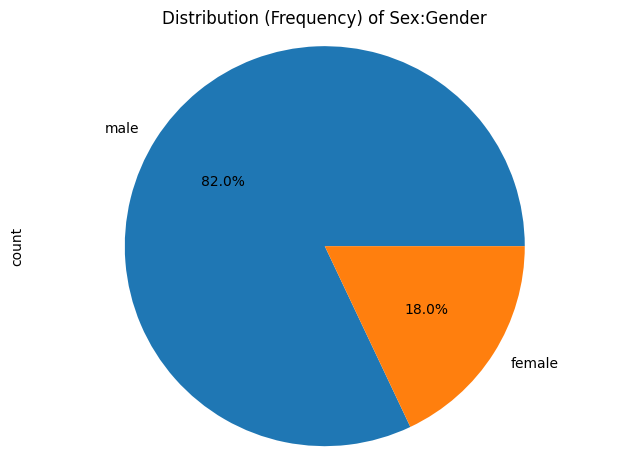

In [16]:
df['Sex'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribution (Frequency) of Sex:Gender')
plt.tight_layout()

#### ***In the Nation column there are different nations . By looking at the distribution it shows the majority country of residence  is United States 59%***


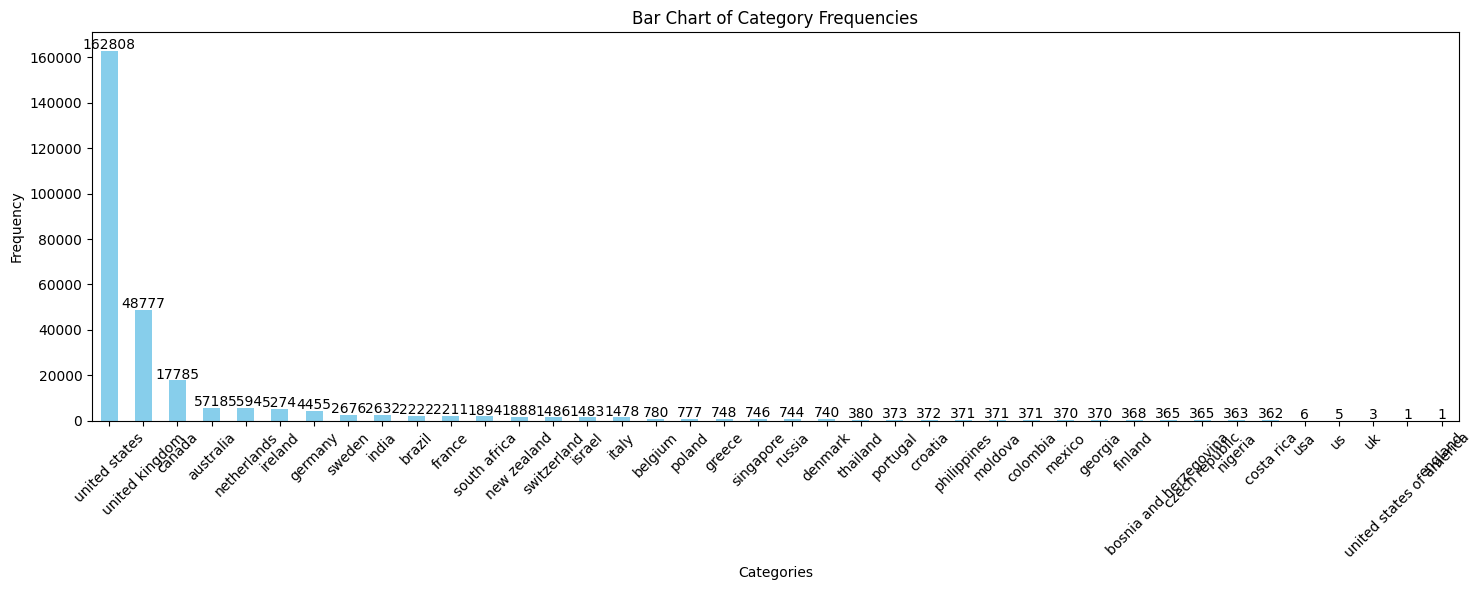

In [17]:
plt.figure(figsize=(15, 6))
df['Nation'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Bar Chart of Category Frequencies')
plt.xticks(rotation=45)
plt.tight_layout()
for p in plt.gca().patches:
    plt.gca().annotate(f'\n{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

#### ***The job column has different job titles and shows occupation of the individual***

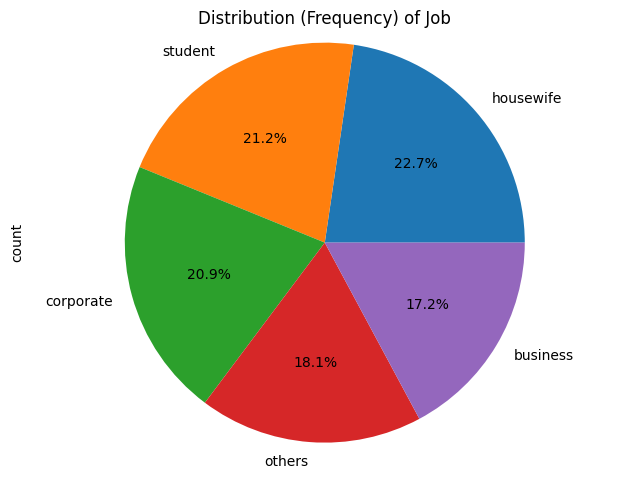

In [18]:
df['Job'].value_counts().plot(kind='pie', autopct='%1.01f%%')
plt.axis('equal')
plt.title('Distribution (Frequency) of Job')
plt.tight_layout()

#### ***The freelance_status column lists the men and women who are freelancing, who isn't, and who has left the column empty.By looking at the distribution it shows 90% said no***

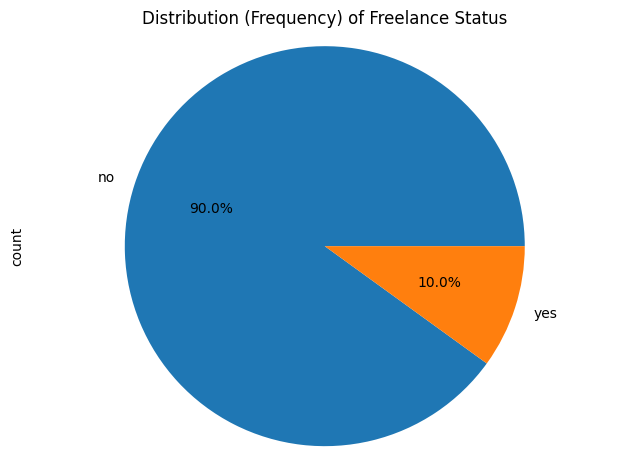

In [19]:
df['Freelance_Status'].value_counts().plot(kind='pie', autopct='%1.01f%%')
plt.axis('equal')
plt.title('Distribution (Frequency) of Freelance Status')
plt.tight_layout()

#### ***The Genetic_Background column indicates whether there is a family history of mental health issues for the person.By the distribution it shows that most of them chose no family history***

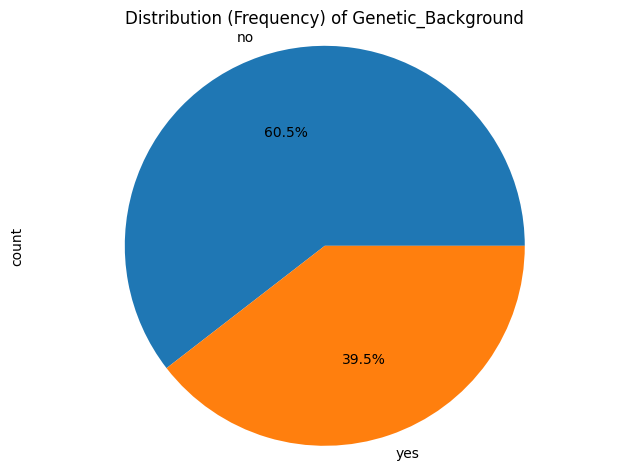

In [20]:
df['Genetic_Background'].value_counts().plot(kind='pie', autopct='%1.01f%%')
plt.axis('equal')
plt.title('Distribution (Frequency) of Genetic_Background')
plt.tight_layout()

### ***This column notes whether the individual has received therapy (yes/no). It helps analyze the effectiveness of therapeutic interventions on emotional stability. By the distribution it shows that almost there is an equal ratio of Yes and No***


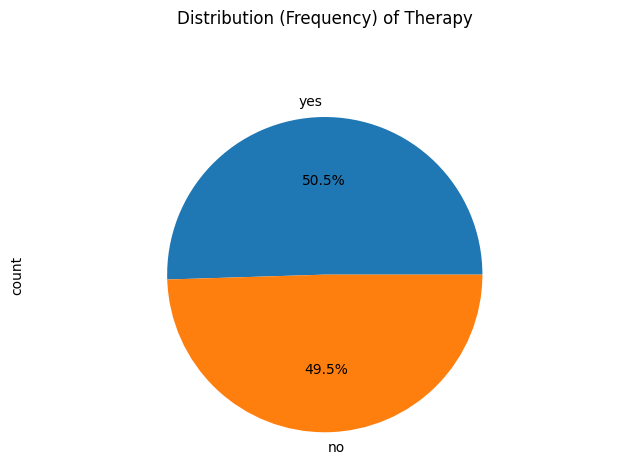

In [21]:
df['Therapy'].value_counts().plot(kind='pie', autopct='%1.01f%%')
plt.axis('equal')
plt.title('Distribution (Frequency) of Therapy', y=1.2)
plt.tight_layout()

8. ### ***This column tracks the number of days the individual has spent indoors. It can be linked to studies on the impact of physical isolation on mental health.***


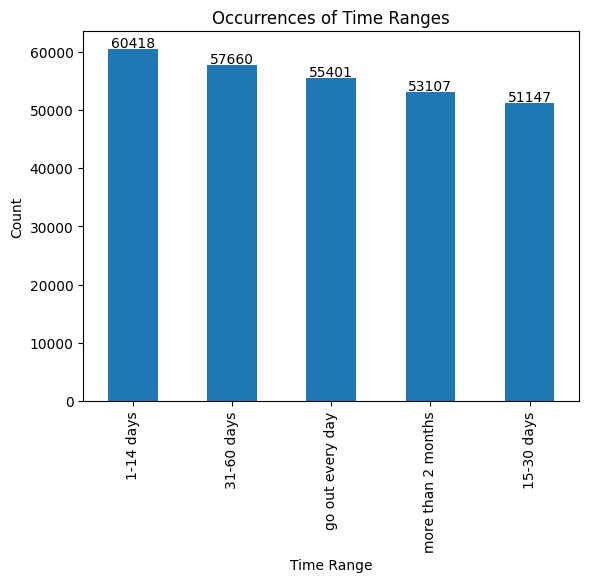

In [22]:
df['Indoor_Days'].value_counts().plot(kind='bar')
plt.title('Occurrences of Time Ranges')
plt.xlabel('Time Range')
plt.ylabel('Count')
for p in plt.gca().patches:
    plt.gca().annotate(f'\n{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

### ***This column measures the levels of growing stress experienced by the individual. It helps in identifying the correlation between stress and emotional fluctuations.The distribution shows that there is an almost an equal raion of maybe,yes and no***


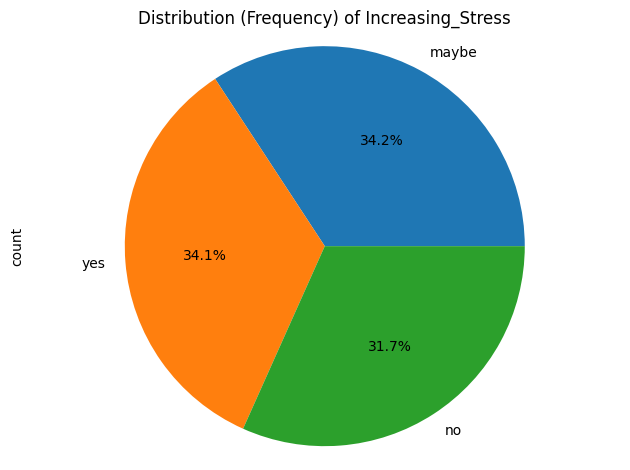

In [23]:
df['Increasing_Stress'].value_counts().plot(kind='pie', autopct='%1.01f%%')
plt.axis('equal')
plt.title('Distribution (Frequency) of Increasing_Stress')
plt.tight_layout()

 ### ***This column records changes in the individual's habits over time.It is used to study their effect on emotional health.The distribution shows that "Yes" has the most percentage***


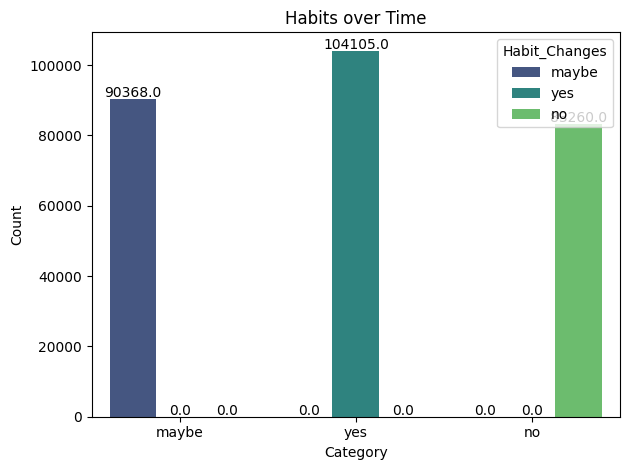

In [24]:
sns.countplot(data=df, x='Habit_Changes', palette='viridis', hue='Habit_Changes')
plt.title('Habits over Time')
plt.xlabel('Category')
plt.ylabel('Count')

for p in plt.gca().patches:
    plt.gca().annotate(f'\n{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()

### ***This column includes information on any past mental health issues the individual has experienced. It helps in understanding the long-term patterns in emotional health.The distribution shows that most of them chose "No"***



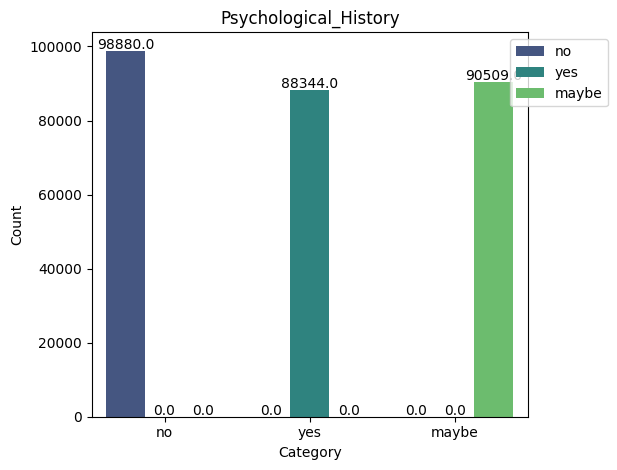

In [25]:
sns.countplot(data=df, x='Psychological_History', palette='viridis', hue='Psychological_History')
plt.title('Psychological_History')
plt.xlabel('Category')
plt.ylabel('Count')

for p in plt.gca().patches:
    plt.gca().annotate(f'\n{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()

### ***This column captures the individual's struggles in coping with changes. It helps in understanding how adaptability influences emotional health.The distribution shows that most of them said "NO"***


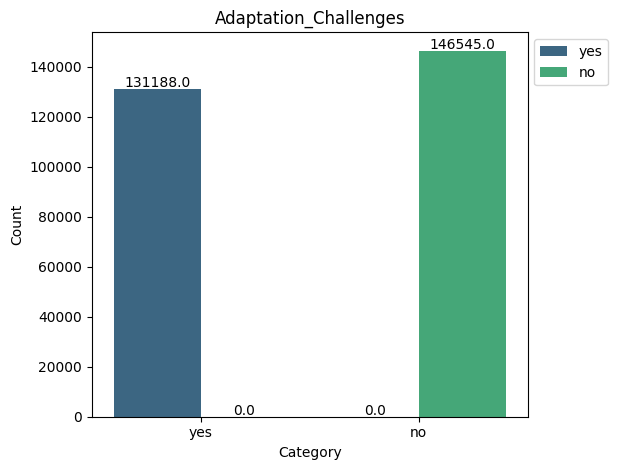

In [26]:
sns.countplot(data=df, x='Adaptation_Challenges', palette='viridis', hue='Adaptation_Challenges')
plt.title('Adaptation_Challenges')
plt.xlabel('Category')
plt.ylabel('Count')

for p in plt.gca().patches:
    plt.gca().annotate(f'\n{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()

### ***This column measures the individual's level of interest and engagement in their work. It can be used to study the relationship between job satisfaction and emotional well-being.The distribution shows that "NO" has the most percentage***


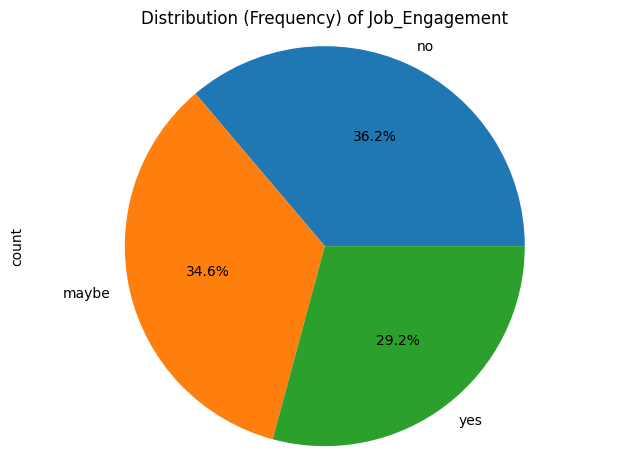

In [27]:
df['Job_Engagement'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribution (Frequency) of Job_Engagement')
plt.tight_layout()

### ***This column assesses the individual's social weaknesses and vulnerabilities. It helps in examining the impact of social factors on emotional health.***


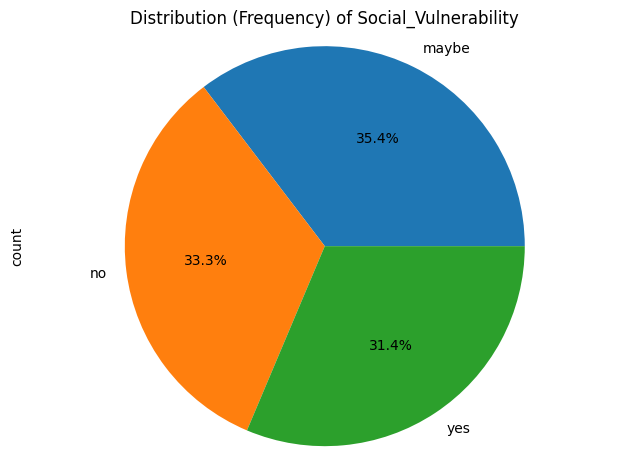

In [28]:
df['Social_Vulnerability'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribution (Frequency) of Social_Vulnerability')
plt.tight_layout()

### This column contains results from mental health evaluations. It provides a clinical perspective on the individual's psychological state.The distribution shows that "NO" has the most percentage

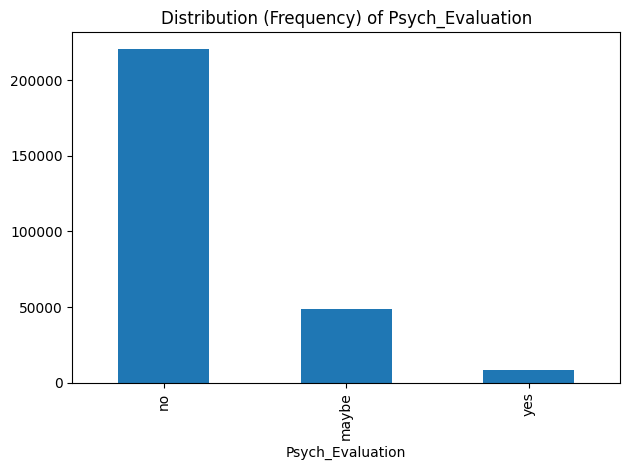

In [29]:
df['Psych_Evaluation'].value_counts().plot(kind='bar')
plt.title('Distribution (Frequency) of Psych_Evaluation')
plt.tight_layout()

### ***This column indicates the availability and use of support options (like counseling, support groups, etc.) for the individual. It helps in evaluating the role of support systems in managing emotional health.The distribution shows that "NO" has the most percentage***


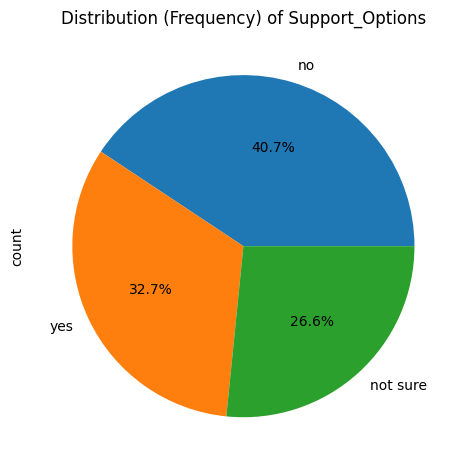

In [30]:
df['Support_Options'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution (Frequency) of Support_Options')
plt.tight_layout()

### ***Distribution of Target Feature***

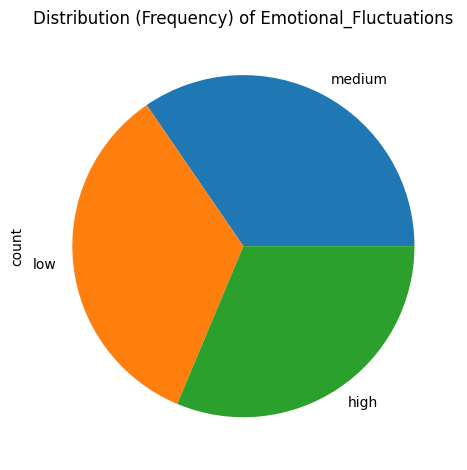

In [31]:
df['Emotional_Fluctuations'].value_counts().plot(kind='pie')
plt.title('Distribution (Frequency) of Emotional_Fluctuations')
plt.tight_layout()

### **Numerical Variable**

In [32]:
train_df['Body_Weight']

0         59.0
1         58.0
2         70.0
3         72.0
4         94.0
          ... 
277741    97.0
277742    96.0
277743    84.0
277744    66.0
277745    74.0
Name: Body_Weight, Length: 277746, dtype: float64

In [33]:
df['Body_Weight'] = train_df['Body_Weight']

### ***Checking the distribution of Body_Weight***

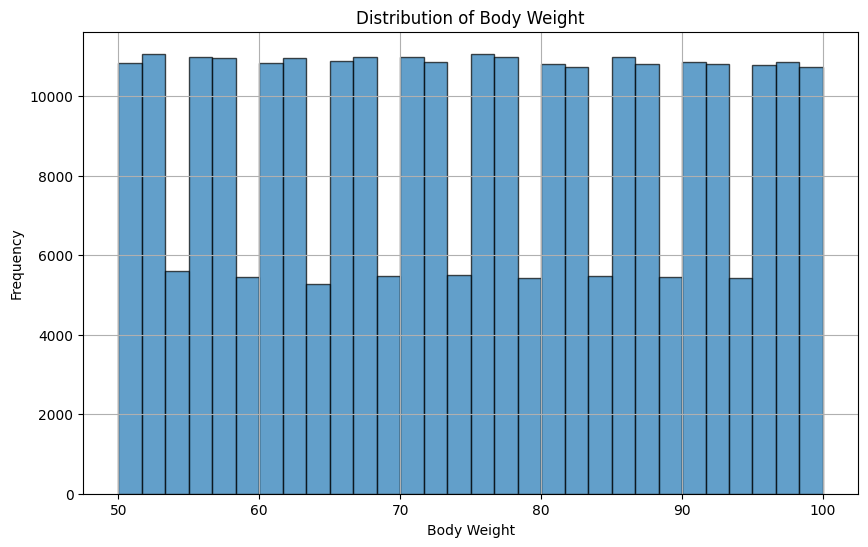

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(df['Body_Weight'].dropna(), bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Body Weight')
plt.xlabel('Body Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## ***`Encode` - many features are categorical so, encode them 1st***

In [35]:
df

,Sex,Nation,Job,Freelance_Status,Genetic_Background,Therapy,Indoor_Days,Increasing_Stress,Habit_Changes,Psychological_History,Emotional_Fluctuations,Adaptation_Challenges,Job_Engagement,Social_Vulnerability,Psych_Evaluation,Support_Options,Body_Weight
0,male,united states,business,no,no,no,15-30 days,maybe,maybe,no,medium,yes,maybe,yes,no,yes,59.0
1,male,united states,student,yes,yes,yes,1-14 days,maybe,yes,no,high,no,yes,maybe,no,not sure,58.0
2,male,us,others,no,no,yes,more than 2 months,no,no,no,high,no,yes,no,no,yes,70.0
3,male,united states,housewife,no,no,yes,15-30 days,maybe,no,no,low,yes,maybe,yes,no,no,72.0
4,male,united states,housewife,no,no,yes,go out every day,yes,yes,no,low,yes,no,no,no,yes,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277741,male,united states,student,no,no,yes,15-30 days,yes,no,maybe,medium,no,yes,maybe,no,yes,97.0
277742,male,united states,student,no,no,no,31-60 days,yes,yes,no,low,no,yes,no,no,no,96.0
277743,male,united states,corporate,no,yes,no,31-60 days,no,yes,maybe,medium,no,no,yes,no,no,84.0
277744,male,united states,business,no,yes,no,15-30 days,no,yes,maybe,medium,yes,maybe,yes,no,not sure,66.0


In [36]:
df.isnull().sum()

Sex                       0
Nation                    0
Job                       0
Freelance_Status          0
Genetic_Background        0
Therapy                   0
Indoor_Days               0
Increasing_Stress         0
Habit_Changes             0
Psychological_History     0
Emotional_Fluctuations    0
Adaptation_Challenges     0
Job_Engagement            0
Social_Vulnerability      0
Psych_Evaluation          0
Support_Options           0
Body_Weight               1
dtype: int64

In [37]:
label_encoders = {}
categorical_columns = df.select_dtypes(include=['object']).columns

for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
    print("Label encoding applied to column:", column)

target = df['Emotional_Fluctuations']
df.drop('Emotional_Fluctuations', axis=1, inplace=True)
df.head()

Label encoding applied to column: Sex
Label encoding applied to column: Nation
Label encoding applied to column: Job
Label encoding applied to column: Freelance_Status
Label encoding applied to column: Genetic_Background
Label encoding applied to column: Therapy
Label encoding applied to column: Indoor_Days
Label encoding applied to column: Increasing_Stress
Label encoding applied to column: Habit_Changes
Label encoding applied to column: Psychological_History
Label encoding applied to column: Emotional_Fluctuations
Label encoding applied to column: Adaptation_Challenges
Label encoding applied to column: Job_Engagement
Label encoding applied to column: Social_Vulnerability
Label encoding applied to column: Psych_Evaluation
Label encoding applied to column: Support_Options


,Sex,Nation,Job,Freelance_Status,Genetic_Background,Therapy,Indoor_Days,Increasing_Stress,Habit_Changes,Psychological_History,Adaptation_Challenges,Job_Engagement,Social_Vulnerability,Psych_Evaluation,Support_Options,Body_Weight
0,1,36,0,0,0,0,1,0,0,1,1,0,2,1,2,59.0
1,1,36,4,1,1,1,0,0,2,1,0,2,0,1,1,58.0
2,1,38,3,0,0,1,4,1,1,1,0,2,1,1,2,70.0
3,1,36,2,0,0,1,1,0,1,1,1,0,2,1,0,72.0
4,1,36,2,0,0,1,3,2,2,1,1,1,1,1,2,94.0


## **Feature Engineering - Lets Explore the features**

### ***`Skewness`***
* Columns like "Sex" and "Nation" have negative skewness, indicating a left skew.
* Freelance_Status" has a high positive skewness, suggesting a right skew.
* Most other columns have skewness values close to zero, indicating relatively symmetric distributions.

In [38]:
df.skew()

Sex                     -1.669198
Nation                  -1.769075
Job                     -0.001707
Freelance_Status         2.671644
Genetic_Background       0.428449
Therapy                 -0.019725
Indoor_Days              0.010714
Increasing_Stress        0.003098
Habit_Changes           -0.092985
Psychological_History    0.014058
Adaptation_Challenges    0.110758
Job_Engagement           0.097262
Social_Vulnerability     0.073466
Psych_Evaluation        -0.788772
Support_Options          0.152280
Body_Weight              0.004369
dtype: float64

### ***1. Feature Scaling***
* StandardScaler - Standardize features by removing the mean and scaling to unit variance
* MinMaxScaler - Scale features to a given range
* RobustScaler - Scale features using statistics that are robust to outliers

In our dataset, we have some features that are right skewed - showcasing some outliers in them.
So, we use RobustScaler instead.

In [39]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(df)

## **XG Boost**

In [90]:
X_train, X_test, y_train, y_test = train_test_split(train_scaled, target, stratify=target, test_size=0.2)

In [93]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'multiclass',
    'num_class': len(set(y_train)),
    'metric': 'multi_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}

num_round = 700
model = lgb.train(params, train_data, num_round, valid_sets=[test_data])
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 146
[LightGBM] [Info] Number of data points in the train set: 222186, number of used features: 16
[LightGBM] [Info] Start training from score -1.161110
[LightGBM] [Info] Start training from score -1.075311
[LightGBM] [Info] Start training from score -1.062271


## **Calculate Evaluation**

In [94]:
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)

Accuracy: 0.9791887950744415


## **Calculating Inference on Test Datatset**

In [71]:
test_df = pd.read_csv('/kaggle/input/tech-fest-1-0-ai-hackathon/test.csv', index_col=0)
test_df.drop('Date_Time', axis=1, inplace=True)

categorical_columns = test_df.select_dtypes(include=['object']).columns

for column in categorical_columns:
    le = LabelEncoder()
    test_df[column] = le.fit_transform(test_df[column])
    label_encoders[column] = le
    print("Label encoding applied to column:", column)

Label encoding applied to column: Sex
Label encoding applied to column: Nation
Label encoding applied to column: Job
Label encoding applied to column: Freelance_Status
Label encoding applied to column: Genetic_Background
Label encoding applied to column: Therapy
Label encoding applied to column: Indoor_Days
Label encoding applied to column: Increasing_Stress
Label encoding applied to column: Habit_Changes
Label encoding applied to column: Psychological_History
Label encoding applied to column: Adaptation_Challenges
Label encoding applied to column: Job_Engagement
Label encoding applied to column: Social_Vulnerability
Label encoding applied to column: Psych_Evaluation
Label encoding applied to column: Support_Options


In [73]:
test_pred = model.predict(test_df, num_iteration=model.best_iteration)

In [74]:
test_pred

array([[0.283353  , 0.2613969 , 0.4552501 ],
       [0.283353  , 0.2613969 , 0.4552501 ],
       [0.283353  , 0.2613969 , 0.4552501 ],
       ...,
       [0.20966622, 0.26234068, 0.5279931 ],
       [0.20966622, 0.26234068, 0.5279931 ],
       [0.20966622, 0.26234068, 0.5279931 ]])